In [1]:
#helper utilities for model training and interpretation 
from helpers import * 
random.seed(1234)
# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



## TTYH2 xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Degenerate Dataset: TTYH2 BC Degenerate</a></li>
    <li><a href=#2>Degenerate Dataset: Feature Subsets</a></li>
    <li><a href=#3>Computational Dataset: TTYH2 (combined) </a></li>
    <li><a href=#4>Computational Dataset Feature Subsets</a></li>
 </ol>


## TTYH2 BC Degenerate features<a name='1'>
<a href=#outline>Home</a>

In [2]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ttyh2_bc_degenerate_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [3]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [6]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(362, 153)


ValueError: `bins` must increase monotonically, when an array

In [12]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [13]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [14]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

mut_ref_nt:C
mut_next_struct:B
u2_5prm_cp_interior
u3_3prm_cp_interior
u2_length_interior_es
d3_exist
mut_prev_struct:B
u1_5prm_cp_hairpin:C:G
u1_5prm_cp_interior
d1_exist
u2_3prm_cp_interior
u1_3prm_cp_interior
u1_exist
d2_5prm_cp_bulge:G:U
d2_3prm_cp_bulge:G:U
u3_5prm_cp_interior
u1_length_interior_ecs
u2_length_interior_ecs
d2_length_hairpin
d2_exist
mut_next_struct:H
u3_length_interior_es
d3_5prm_cp_hairpin
u3_length_interior_ecs
d3_length_hairpin
mut_nt:G
mut_exist
mut_pos
u2_5prm_cp_bulge:U:A
mut_site_dist
mut_prev_struct:I
u1_length_interior_es
d1_length_hairpin
u3_3prm_cp_bulge:U:A
mut_ref_nt:G
d2_5prm_cp_bulge:C:G
u2_5prm_cp_hairpin:U:G
mut_ref_nt:U
mut_nt:A
d2_3prm_cp_interior:G:U
mut_ref_nt:A
site_5prm_cp_bulge:G:U
d2_3prm_cp_interior:A:U
d2_5prm_cp_hairpin
site_5prm_cp_bulge:C:G
mut_type:mismatch
d1_5prm_cp_hairpin
d2_3prm_cp_bulge:G:C
u2_5prm_cp_bulge:G:U


In [15]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [16]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [17]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(501, 133)
(501,)
(98, 133)
(98,)
(160, 133)
(160,)


In [18]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [19]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [20]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [21]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.945915	eval-mae:0.337093	eval-map:1	eval-aucpr:0.465731	eval-rmse:0.34131	train-auc:0.962305	train-mae:0.314966	train-map:1	train-aucpr:0.644316	train-rmse:0.326559
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.945527	eval-mae:0.238639	eval-map:1	eval-aucpr:0.46139	eval-rmse:0.242209	train-auc:0.962709	train-mae:0.223788	train-map:1	train-aucpr:0.648213	train-rmse:0.232659
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.950205	eval-mae:0.168995	eval-map:1	eval-aucpr:0.562395	eval-rmse:0.172634	train-auc:0.96435	train-mae:0.159992

[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.971762	eval-mae:0.009496	eval-map:1	eval-aucpr:0.576799	eval-rmse:0.032749	train-auc:0.970771	train-mae:0.008475	train-map:1	train-aucpr:0.713594	train-rmse:0.036189
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.972585	eval-mae:0.009437	eval-map:1	eval-aucpr:0.57686	eval-rmse:0.032758	train-auc:0.970799	train-mae:0.008435	train-map:1	train-aucpr:0.713617	train-rmse:0.036182
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.972629	eval-mae:0.009419	eval-map:1	eval-aucpr:0.576865	eval-rmse:0.032758	train-auc:0.970838	train-mae:0.008388	train-map:1	train-aucpr:0.713634	train-rmse:0.036175
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extr

[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[54]	eval-auc:0.971443	eval-mae:0.009258	eval-map:1	eval-aucpr:0.576653	eval-rmse:0.032566	train-auc:0.971185	train-mae:0.007986	train-map:1	train-aucpr:0.71392	train-rmse:0.036097
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[55]	eval-auc:0.971443	eval-mae:0.009258	eval-map:1	eval-aucpr:0.576653	eval-rmse:0.032566	train-auc:0.971185	train-mae:0.007986	train-map:1	train-aucpr:0.71392	train-rmse:0.036097
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[56]	eval-auc:0.971443	eval-mae:0.009258	eval-map:1	eval-aucpr:0.576653	eval-rmse:0.032566	train-auc:0.971185	train-mae:0.007986	train-map:1	train-aucpr:0.71392	train-rmse:0.036097
[10:09:14] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra node

In [22]:
# save to binary file for faster loading
bst.save_model('neil1.degenerate.model')
# save model to text file 
bst.dump_model('neil1.degenerate.raw.txt', 'featmap.txt')


In [23]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

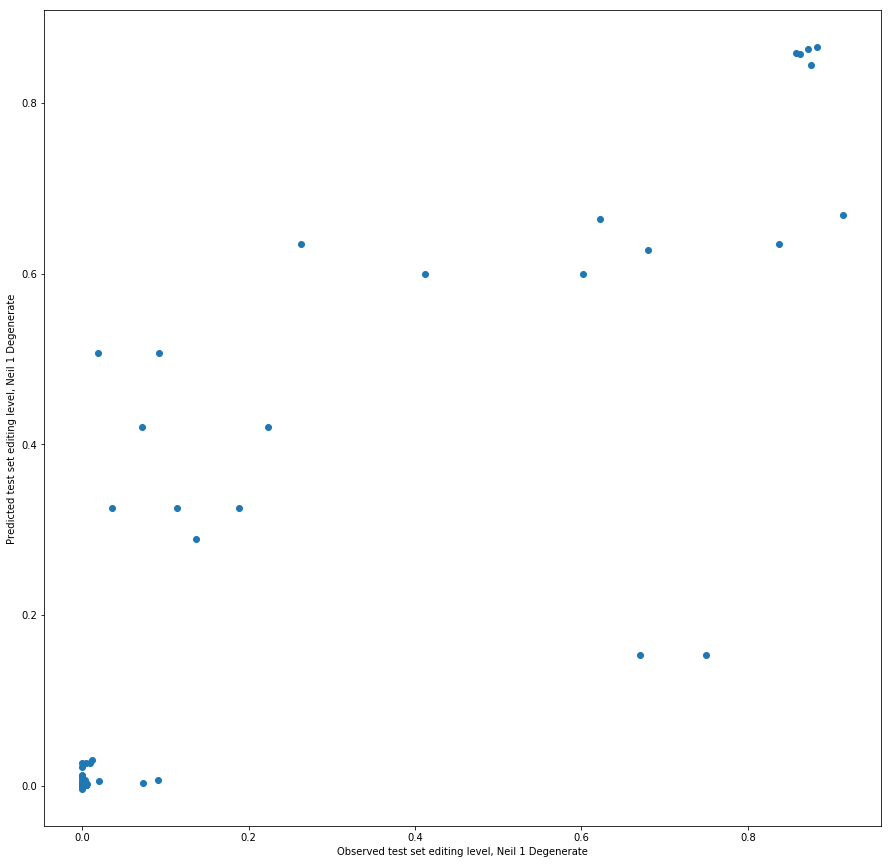

In [24]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")
plt.show()

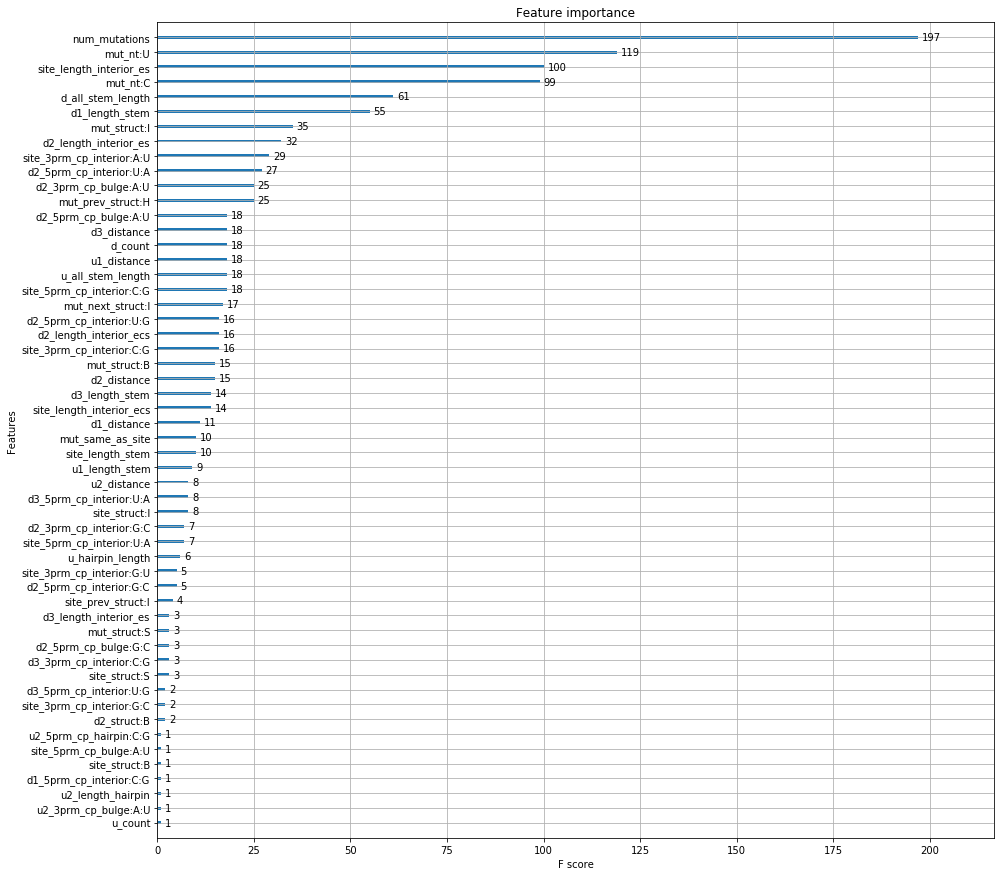

In [25]:
xgboost.plot_importance(bst)

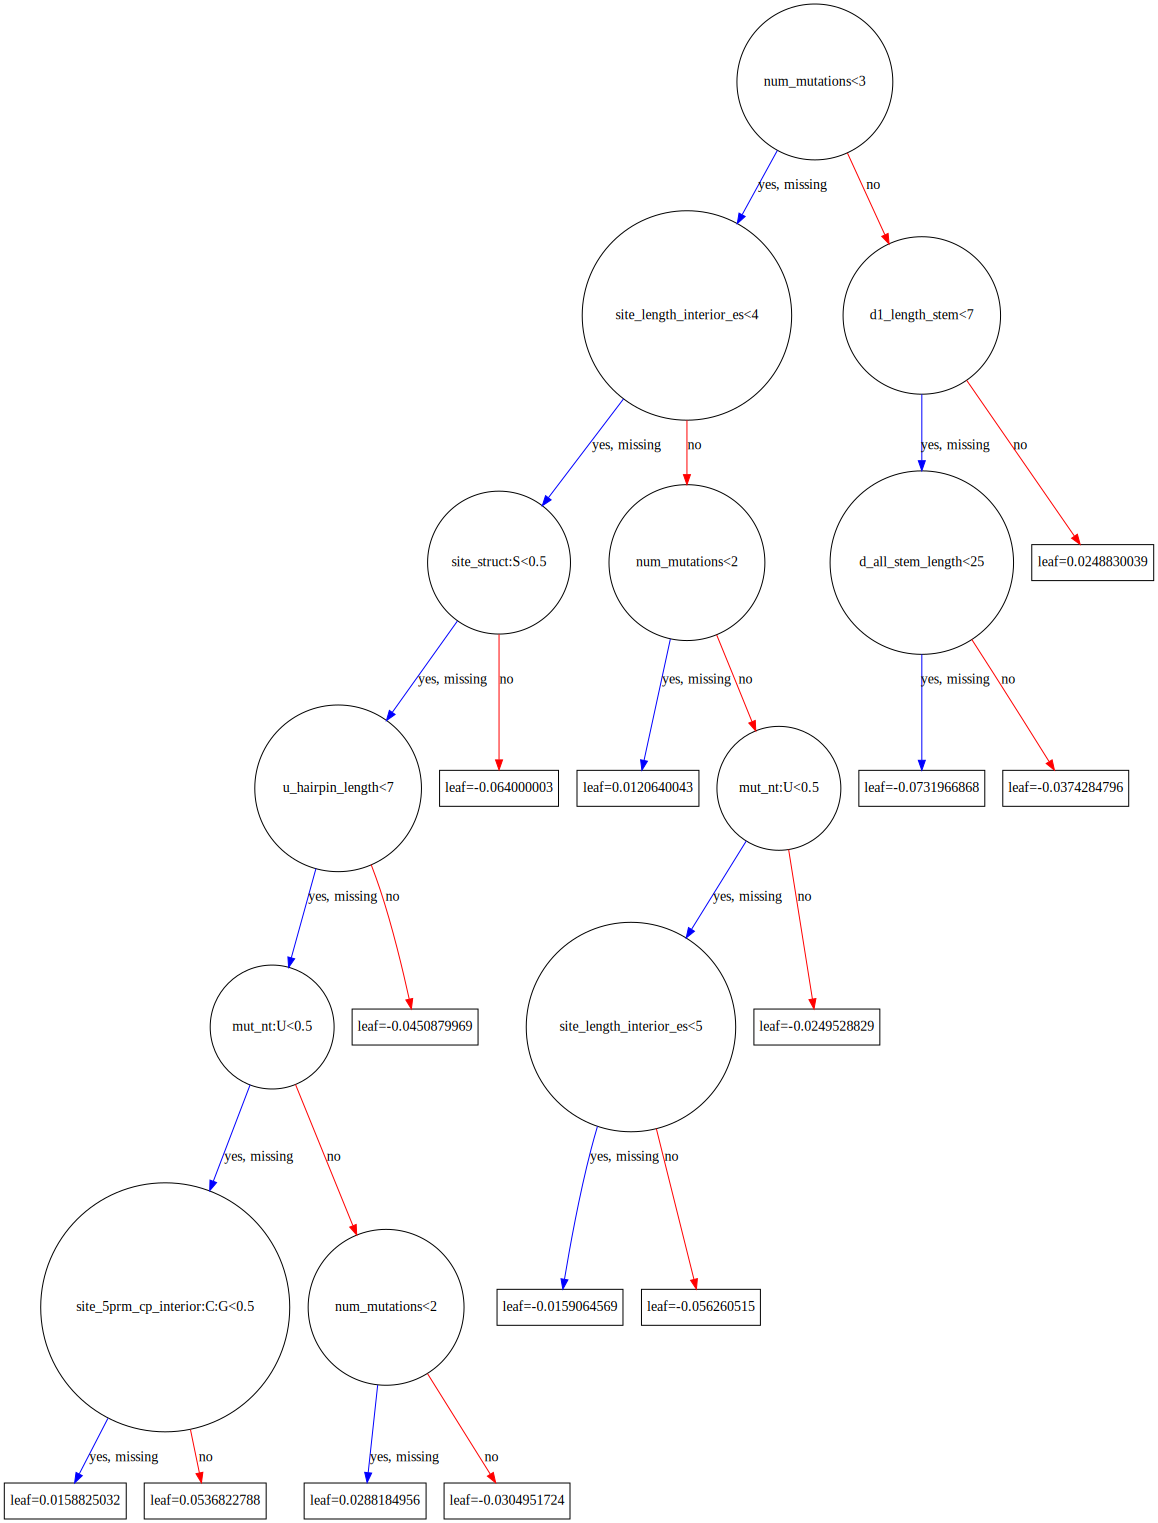

In [26]:
xgboost.to_graphviz(bst, num_trees=2)


In [27]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [28]:
shap_values.shape

(160, 133)

In [29]:
# visualize the first prediction's explanation -- this has the highest editing level 
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [31]:
# visualize the last prediction's explanation -- this has the lowest editing level 
shap.force_plot(explainer.expected_value, shap_values[133,:], test_X.iloc[133,:])

In [32]:
test_y

[0.9145,
 0.8835,
 0.858,
 0.8755,
 0.873,
 0.863,
 0.8375,
 0.7495,
 0.6805,
 0.623,
 0.67,
 0.602,
 0.412,
 0.2235,
 0.2625,
 0.1365,
 0.1885,
 0.07200000000000001,
 0.114,
 0.0365,
 0.092,
 0.019,
 0.012,
 0.0205,
 0.0055,
 0.005,
 0.005,
 0.0045,
 0.0045,
 0.0045,
 0.009000000000000001,
 0.0045,
 0.004,
 0.004,
 0.0035,
 0.0035,
 0.0035,
 0.003,
 0.0025,
 0.005,
 0.002,
 0.0025,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0045,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0025,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0025,
 0.0,
 0.0,
 0.0,
 0.002,
 0.0,
 0.0,
 0.073,
 0.0,
 0.0,
 0.0,
 0.003,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.004,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0035,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.002,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[<matplotlib.lines.Line2D at 0x7f1fce9499b0>]

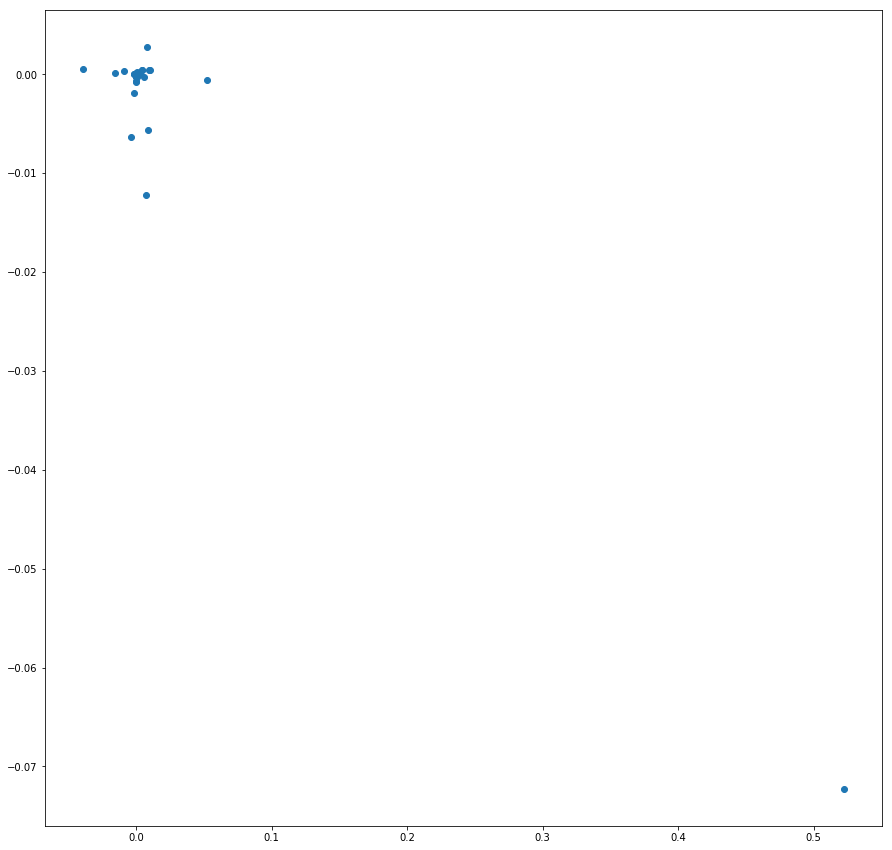

In [34]:
#As expected, the shap values for the highest edited test datapoint and the lowest edited test datapoint
# appear inversely correlated 
highest=shap_values[0]
lowest=shap_values[133]
plt.plot(highest,lowest,'o')

In [36]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values,train_X)

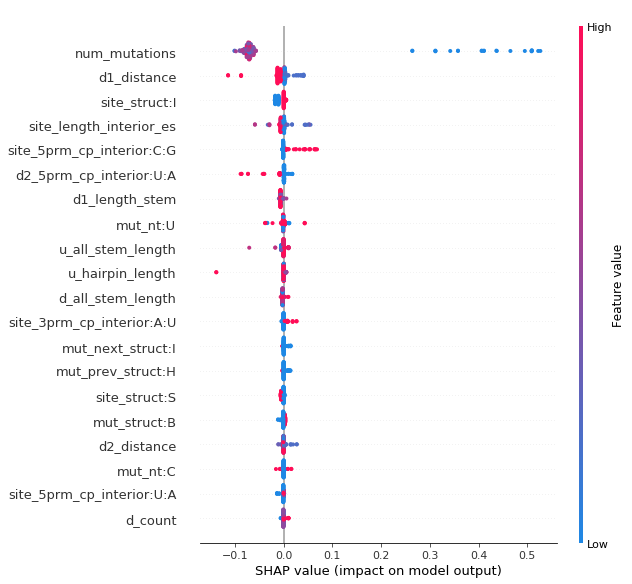

In [37]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


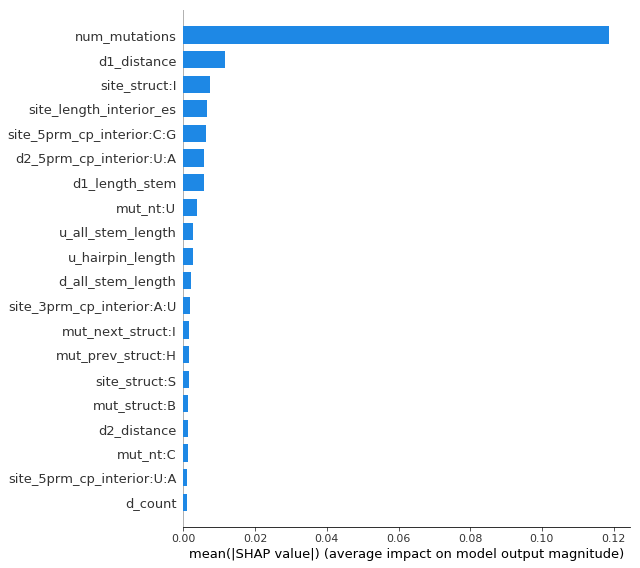

In [38]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

## Degenerate Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

## Neil1 Computational features <a name='3'>
<a href=#outline>Home</a>

In [39]:
data=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [40]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [41]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(407, 188)


In [42]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [43]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [44]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

site_struct:S
u1_struct:B
u2_5prm_cp_bulge:C:G
u3_5prm_cp_bulge:U:G
d2_5prm_cp_hairpin:C:G
site_5prm_cp_hairpin:G:C
u1_3prm_cp_bulge:A:U
d2_3prm_cp_interior:U:A
u3_3prm_cp_interior
d2_5prm_cp_interior:G:U
u1_5prm_cp_hairpin:C:G
d1_exist
u1_exist
d1_5prm_cp_interior:U:G
d2_3prm_cp_bulge:G:U
site_prev_struct:H
d1_5prm_cp_bulge
d1_length_interior_es
mut_struct:H
u2_5prm_cp_hairpin:U:A
d1_struct:S
site_struct:H
site_length_bulge
d2_3prm_cp_interior:G:U
mut_ref_nt:A
d2_struct:H
mut_type:mismatch
site_5prm_cp_interior:A:U
u2_5prm_cp_bulge:G:U
d1_3prm_cp_interior:G:C
d3_3prm_cp_bulge:C:G
site_5prm_cp_bulge:A:U
d2_5prm_cp_bulge:A:U
site_5prm_cp_interior:G:C
u2_3prm_cp_interior
site_struct:B
site_prev_struct:S
d1_length_interior_ecs
u2_length_interior_ecs
u3_length_interior_es
d3_length_hairpin
d3_struct:I
site_3prm_cp_bulge:G:C
u1_length_hairpin
d1_length_hairpin
d2_struct:S
u1_5prm_cp_bulge:G:U
u2_5prm_cp_hairpin:U:G
mut_ref_nt:U
d1_3prm_cp_bulge
site_3prm_cp_interior:C:G
u1_5prm_cp_bulge:C:G

In [45]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [46]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [47]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(268, 76)
(268,)
(61, 76)
(61,)
(62, 76)
(62,)


In [62]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [63]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [64]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [65]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-auc:0.745893	eval-mae:0.246859	eval-map:1	eval-aucpr:0.412913	eval-rmse:0.274694	train-auc:0.810437	train-mae:0.210255	train-map:1	train-aucpr:0.558513	train-rmse:0.245176
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-auc:0.737438	eval-mae:0.186857	eval-map:1	eval-aucpr:0.420617	eval-rmse:0.211697	train-auc:0.817704	train-mae:0.157176	train-map:1	train-aucpr:0.571759	train-rmse:0.18195
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-auc:0.769552	eval-mae:0.151555	eval-map:1	eval-aucpr:0.430595	eval-rmse:0.176573	train-auc:0.821698	train-mae:0.1194

[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.789565	eval-mae:0.084795	eval-map:1	eval-aucpr:0.438297	eval-rmse:0.133316	train-auc:0.836439	train-mae:0.02099	train-map:1	train-aucpr:0.592586	train-rmse:0.04226
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.790579	eval-mae:0.08516	eval-map:1	eval-aucpr:0.442401	eval-rmse:0.133483	train-auc:0.836564	train-mae:0.020431	train-map:1	train-aucpr:0.592748	train-rmse:0.041814
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.790365	eval-mae:0.085235	eval-map:1	eval-aucpr:0.442204	eval-rmse:0.133493	train-auc:0.836607	train-mae:0.020154	train-map:1	train-aucpr:0.59283	train-rmse:0.041654
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra n

[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-auc:0.789299	eval-mae:0.086581	eval-map:1	eval-aucpr:0.429153	eval-rmse:0.134838	train-auc:0.83711	train-mae:0.015371	train-map:1	train-aucpr:0.593655	train-rmse:0.039133
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-auc:0.789299	eval-mae:0.086499	eval-map:1	eval-aucpr:0.429153	eval-rmse:0.134788	train-auc:0.837129	train-mae:0.015157	train-map:1	train-aucpr:0.593673	train-rmse:0.039055
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-auc:0.789814	eval-mae:0.086535	eval-map:1	eval-aucpr:0.429482	eval-rmse:0.134823	train-auc:0.837142	train-mae:0.015052	train-map:1	train-aucpr:0.593684	train-rmse:0.03902
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra

[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[81]	eval-auc:0.789352	eval-mae:0.087438	eval-map:1	eval-aucpr:0.433873	eval-rmse:0.135253	train-auc:0.83725	train-mae:0.013257	train-map:1	train-aucpr:0.593838	train-rmse:0.038622
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[82]	eval-auc:0.789352	eval-mae:0.087373	eval-map:1	eval-aucpr:0.433873	eval-rmse:0.135244	train-auc:0.837251	train-mae:0.01322	train-map:1	train-aucpr:0.593839	train-rmse:0.038616
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[83]	eval-auc:0.789352	eval-mae:0.087404	eval-map:1	eval-aucpr:0.433873	eval-rmse:0.135253	train-auc:0.837252	train-mae:0.013197	train-map:1	train-aucpr:0.593839	train-rmse:0.038612
[10:13:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra

In [66]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt', 'featmap.txt')


In [67]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

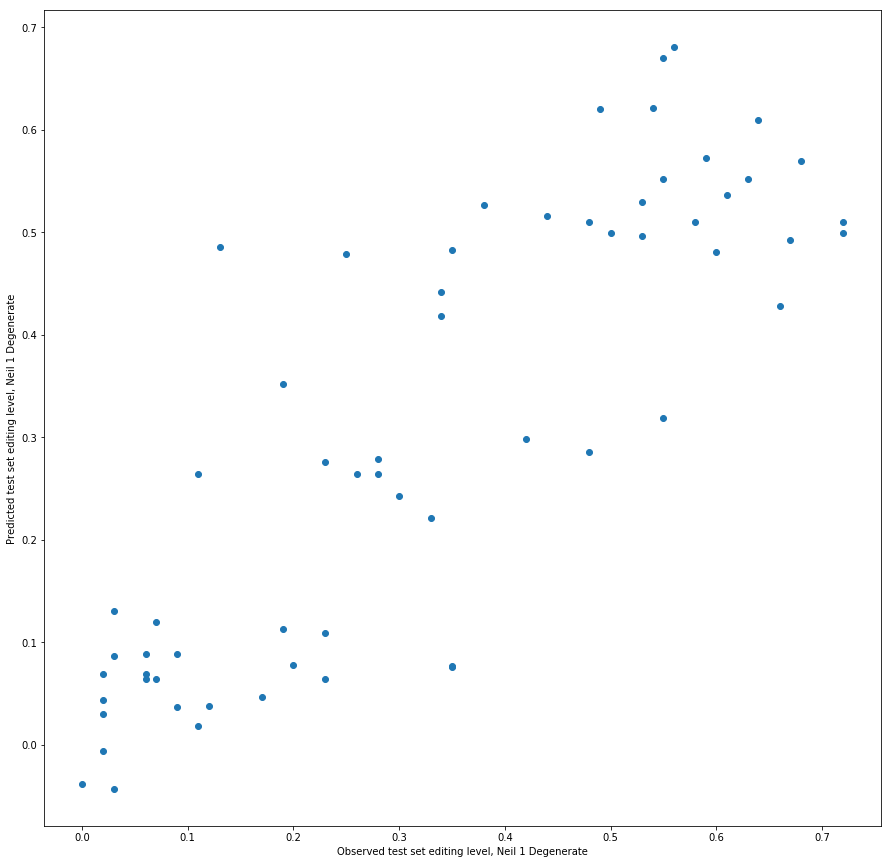

In [68]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")
plt.show()

In [71]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [78]:
shap_values.shape

(62, 76)

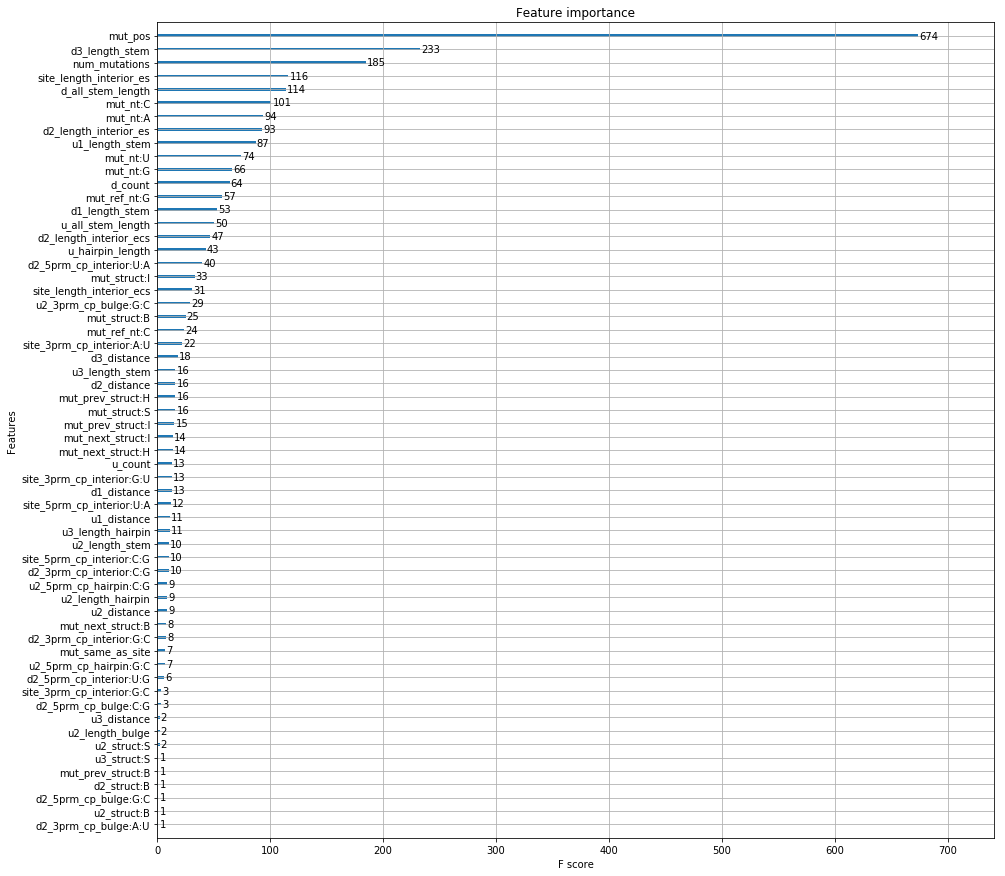

In [72]:
xgboost.plot_importance(bst)

In [73]:
# visualize the first prediction's explanation -- this has the highest editing level 
shap.force_plot(explainer.expected_value, shap_values[0,:], test_X.iloc[0,:])

In [80]:
# visualize the last prediction's explanation -- this has the lowest editing level 
shap.force_plot(explainer.expected_value, shap_values[61,:], test_X.iloc[61,:])

In [85]:
test_y

[0.56,
 0.49,
 0.54,
 0.68,
 0.44,
 0.55,
 0.55,
 0.34,
 0.63,
 0.53,
 0.64,
 0.58,
 0.59,
 0.53,
 0.34,
 0.13,
 0.6,
 0.33,
 0.25,
 0.35,
 0.09,
 0.07,
 0.17,
 0.07,
 0.35,
 0.02,
 0.02,
 0.02,
 0.03,
 0.09,
 0.06,
 0.2,
 0.42,
 0.02,
 0.19,
 0.5,
 0.66,
 0.19,
 0.67,
 0.28,
 0.28,
 0.55,
 0.72,
 0.72,
 0.61,
 0.11,
 0.48,
 0.06,
 0.35,
 0.23,
 0.3,
 0.38,
 0.06,
 0.23,
 0.23,
 0.26,
 0.48,
 0.11,
 0.03,
 0.12,
 0.0,
 0.03]

In [86]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values,train_X)

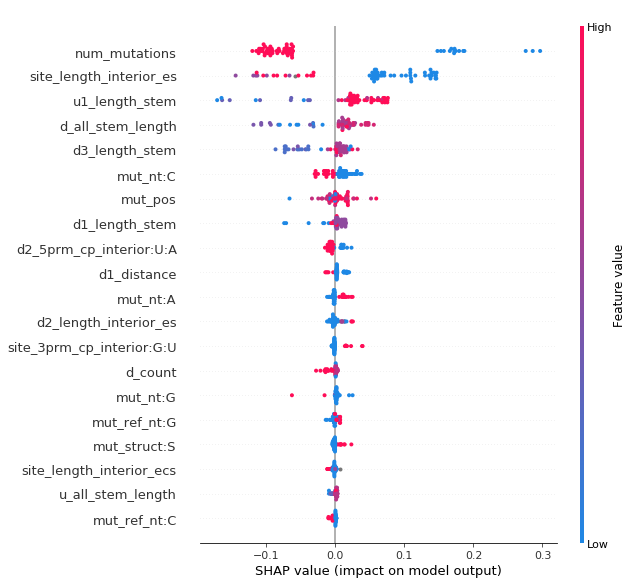

In [87]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


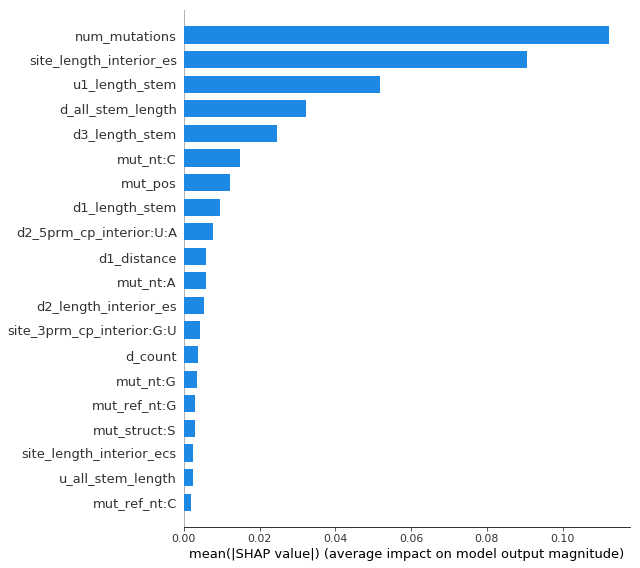

In [88]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

## Computational Dataset: Feature Subsets<a name='4'>
<a href=#outline>Home</a>